# Northwind Dataset - Statistical Analysis

In [599]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')
from statsmodels.stats.power import TTestIndPower
from pandas.plotting import table 

# Summary and Conclusions

## Q1 Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
 - Considering all products discounted items are drawn from a different distribution compared to undiscounted items at the 95% confidence level
 - Considering individual discount levels, discounted products at 0.05, 0.15, 0.2, and 0.25 levels are drawn from a a different distribution compared to the undiscounted quantities and have higher means. There is no concrete distinction in the distributions between 0.05, 0.15, 0.2 and 0.25 levels. 0.1 discount level needs to have more data points for us to potentially reject the null hypothesis
 - At the individual product level there is no evidence that discount levels matter, However that is most likely due to low statistics per product and per discount level.
 
## Q2 Do sales get drawn from a different distribution every year? Does the month when the products were ordered matter? 
 - The sales do not seem to depend on year and the quantities seem to be drawn from the same underlying distribution. Individual products also don't suggest a preferred year
 - For overall sales the month of May shows a definite decrease in quantities purchased


## Q3 Is there a standout employee in terms of the distribution from which quantities sold are drawn ? Are there employees who are shipping their orders significantly late?
 - There is insufficient evidence that the quantities sold between employees come from different distributions
 - Employees 2,4,7,9 statistically have a bad record of shipping on time compared to Employee 5

## Q4 Are there regions that are growing or decreasing in overall sales ? Are there products that are growing or decreasing in overall sales
 - All regions show a growth comparing year 2012 and 2014
 - All products show a growth comparing year 2012 and 2014


## Connecting to SQL database

In [600]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

## Q1 Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [601]:
cur.execute(""" SELECT * FROM orderdetail;""")

df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(df.shape)
df.head()

(2155, 6)


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


#### Verifying that there are no missing entries

In [602]:
print(df.dtypes)
df.isna().sum()

Id            object
OrderId        int64
ProductId      int64
UnitPrice    float64
Quantity       int64
Discount     float64
dtype: object


Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

####  Lets start with discount 0 vs any discount discount > 0. We will at first see the quanity ordered for all products

#### Throughout the analysis we need to specify what our hypothesis is. We will set our tolerance value  $\alpha=0.05$. We will be performing the two tailed tests. Our Null hypothesis is that the the quantities ordered at various discount prices have the same mean as that of zero discount price. Our alternative hypothesis is that the means of the distributions at higher discount prices are different from that of discount price zero. Thus this is a two tailed hypothesis test. Since the variance of the two distributions can be different and the sample sizes are not the same we need to do a Welch's t-test. We will also perform a Kolmogorov-Smirnov test.

In [595]:
analysis_df = df[['ProductId','Quantity','Discount']]

analysis_df_nodisc = analysis_df[analysis_df.Discount==0]
analysis_df_disc = analysis_df[analysis_df.Discount >0]

#### Checking normality of the distributions.

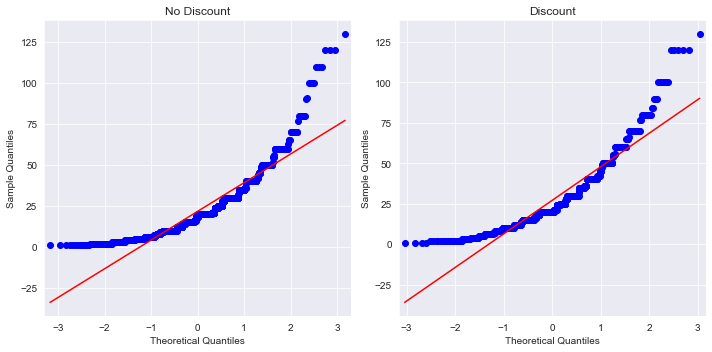

In [596]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs = axs.ravel()
sm.qqplot(analysis_df_nodisc['Quantity'],line='s',ax=axs[0])
axs[0].set_title('No Discount')
sm.qqplot(analysis_df_disc['Quantity'],line='s',ax=axs[1])
axs[1].set_title('Discount')
plt.tight_layout()
#plt.savefig('Figures\qq_disc.png')

#### Distributions are clearly not normal. Welch's t-test assumes normality or near normality of the underlying distributions. So we will take a Monte carlo approach of comparing means as well as using Welch's t-test and KS test

In [675]:
def mc_pvalue(df1,df2,samples=1000,one_tail=True):
    mean_diff = abs(df1.mean() - df2.mean())
    df_merge = pd.concat([df1,df2])
    diff_means = []
    for i in range(samples):
        sample_1 = df_merge.sample(len(df1))
        sample_2 = df_merge.drop(sample_1.index)
        diff_means.append(sample_1.mean()-sample_2.mean())
    if one_tail:
        p_val = sum(np.array(diff_means) > mean_diff)/samples
    else:
        p_val = 2*sum(np.array(diff_means) > mean_diff)/samples
    
    return p_val

#### Plotting the original distributions and their means

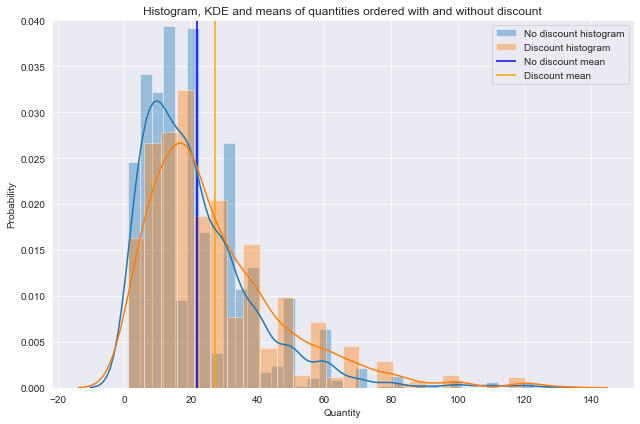

In [264]:
plt.figure(figsize=(9,6))
plt.ylim([0,0.04])
plt.vlines(analysis_df_nodisc['Quantity'].mean(),0,0.04,color='b',label='No discount mean')
plt.vlines(analysis_df_disc['Quantity'].mean(),0,0.04,color='orange',label='Discount mean')
sns.distplot(analysis_df_nodisc['Quantity'],label='No discount histogram')
sns.distplot(analysis_df_disc['Quantity'],label='Discount histogram')
plt.ylabel('Probability')
plt.legend()
plt.title('Histogram, KDE and means of quantities ordered with and without discount')
plt.tight_layout()
plt.savefig('Figures\distplot_disc.png')


#### The distributions are not exactly normal. But we will perform a Welch's t-test on the log transformed distributions. We will also perform a KS test

In [664]:
print('The p-value that the log transformed no discount and the discounted quatities come from the same distribution using the \n Welch t-test is',ttest_ind(analysis_df_nodisc['Quantity'],analysis_df_disc['Quantity'],equal_var=False)[1])
print('The p-value that the no discount and the discounted quatities come from the same distribution using the KS test is \n',ks_2samp(analysis_df_nodisc['Quantity'],analysis_df_disc['Quantity'])[1])
print('The p-value that the no discount and the discounted quatities come from the same distribution using Montecarlo is \n',mc_pvalue(analysis_df_nodisc['Quantity'],analysis_df_disc['Quantity']))



The p-value that the log transformed no discount and the discounted quatities come from the same distribution using the 
 Welch t-test is 5.65641429030433e-10
The p-value that the no discount and the discounted quatities come from the same distribution using the KS test is 
 4.880136585949657e-07
The p-value that the no discount and the discounted quatities come from the same distribution using Montecarlo is 
 0.0


#### Its clear that the quantities come from different distributuions

In [665]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x,ddof=1)
    sy = np.std(y,ddof=1)
    return (mx - my) / np.sqrt(((nx-1)*(sx ** 2) + (ny-1)*(sy** 2)) / dof)

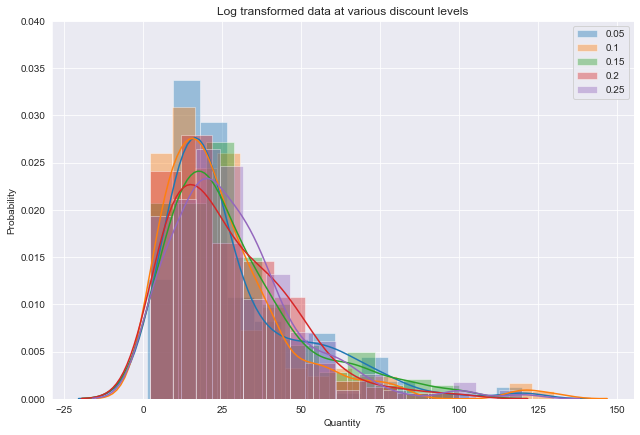

In [680]:
power_analysis = TTestIndPower()

plt.figure(figsize=(9,6))
#plt.xlim([0,10])
plt.ylim([0,.04])
plt.ylabel('Probability')
disc = analysis_df.Discount.unique()
disc.sort()
stat = np.zeros([5,5])
ix = 0
for d in disc[1:]:
    df_plot = analysis_df[analysis_df.Discount==d]['Quantity']
    if len(df_plot) >10:
        sns.distplot(df_plot,label=str(d))
        stat[ix,0] = d
        stat[ix,1] = mc_pvalue(df_plot,analysis_df_nodisc['Quantity'],samples=100000,one_tail=False)
        stat[ix,2] = format(ttest_ind(df_plot,analysis_df_nodisc['Quantity'],equal_var=False)[1],'.2e')
        stat[ix,3] = format(ks_2samp(np.log1p(df_plot),np.log1p(analysis_df_nodisc['Quantity']))[1],'.2e')
        stat[ix,4] = format(power_analysis.solve_power(effect_size = cohen_d(df_plot,analysis_df_nodisc['Quantity']),
                                                alpha = 0.05, nobs1 = len(df_plot)),'.2e')
        
        ix = ix+1
        
plt.tight_layout()
plt.title('Log transformed data at various discount levels')
plt.legend()
plt.savefig('Figures\distplot_all.png')
stat_df = pd.DataFrame(stat, columns=['Discount','MC','Welch','KS','Power'])



In [681]:
stat_df

,Discount,MC,Welch,KS,Power
0,0.05,0.00004,0.000272,0.001530,0.914
1,0.10,0.02000,0.037500,0.153000,0.443
2,0.15,0.00002,0.000172,0.002000,0.908
3,0.20,0.00068,0.000811,0.005980,0.767
4,0.25,0.00004,0.000159,0.000082,0.894


#### Note that MC = 0 reflects that $p < \frac{1}{sample} = 10^{-5}$ in this case

#### Almost all the quantities for different distributions at different discount levels even after taking into account the multiple coparisons problem, except for discount of 10%. It's most likely true that 10% also will confirm our hypothesis. We can conduct a statistical power test to find out how many more samples of 10% are needed to confirm our hypothesis.

In [308]:
eff = (np.log1p(analysis_df_nodisc['Quantity']).mean()-np.log1p(analysis_df[analysis_df.Discount==0.1]['Quantity']).mean())/np.log1p(analysis_df_nodisc['Quantity']).std(ddof=1)
print('The minimum required number of observations to reject the Null Hypothesis is', round(power_analysis.solve_power(
    effect_size=eff,alpha=0.05,
    power=0.8)),'whereas currently we have',len(analysis_df[analysis_df.Discount==0.1]['Quantity']),'observations')

The minimum required number of observations to reject the Null Hypothesis is 462 whereas currently we have 173 observations


#### The discount levels that clearly make a difference are not significantly distinguishable from each other. One might be tempted to conclude that discounts above 5% don't matter and one should stick to lowest possible discount to maximize revenue. However one has to be careful about drawing such a conclusion, since higher discounts might be responsible for maintaining robust sales.

In [96]:
df_5 = analysis_df[analysis_df.Discount==0.05]['Quantity']
df_15 = analysis_df[analysis_df.Discount==0.15]['Quantity']
df_20 = analysis_df[analysis_df.Discount==0.2]['Quantity']
df_25 = analysis_df[analysis_df.Discount==0.25]['Quantity']

dfs = [df_5,df_15,df_20,df_25]
p_val_dfs = np.zeros([len(dfs),len(dfs)])
for i,d1 in enumerate(dfs):
    for j,d2 in enumerate(dfs):
        p_val_dfs[i,j] = ttest_ind(np.log1p(d1),np.log1p(d2),equal_var=False)[1]

p_val_dfs

array([[1.        , 0.80406887, 0.87601046, 0.84281215],
       [0.80406887, 1.        , 0.69610117, 0.9659553 ],
       [0.87601046, 0.69610117, 1.        , 0.7343864 ],
       [0.84281215, 0.9659553 , 0.7343864 , 1.        ]])

## Doing the test for individual product

#### Now let's compare  different discount levels to that of no discount

In [312]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array_disc = []
p_val_array_ks_disc = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    b = df_id[df_id.Discount!=disc[0]]['Quantity']
    p_val_array_disc.append(ttest_ind(a,b,equal_var=False)[1])
    p_val_array_ks_disc.append(ks_2samp(a,b)[1])

print('Number of products that have a p-value < 0.05 using Welch is ', (np.array(p_val_array_disc) < 0.05).sum(), ' whereas the expected number under the null hypothesis', round(len(prod_id)*0.05) )
print('Number of products that have a p-value < 0.05 using KS is ', (np.array(p_val_array_ks_disc) < 0.05).sum(), ' whereas the expected number under the null hypothesis', round(len(prod_id)*0.05) )

Number of products that have a p-value < 0.05 using Welch is  3  whereas the expected number under the null hypothesis 4
Number of products that have a p-value < 0.05 using KS is  2  whereas the expected number under the null hypothesis 4


#### Visually does not seem like there is a dependence on discount price

#### Checking if individual discount levels matter

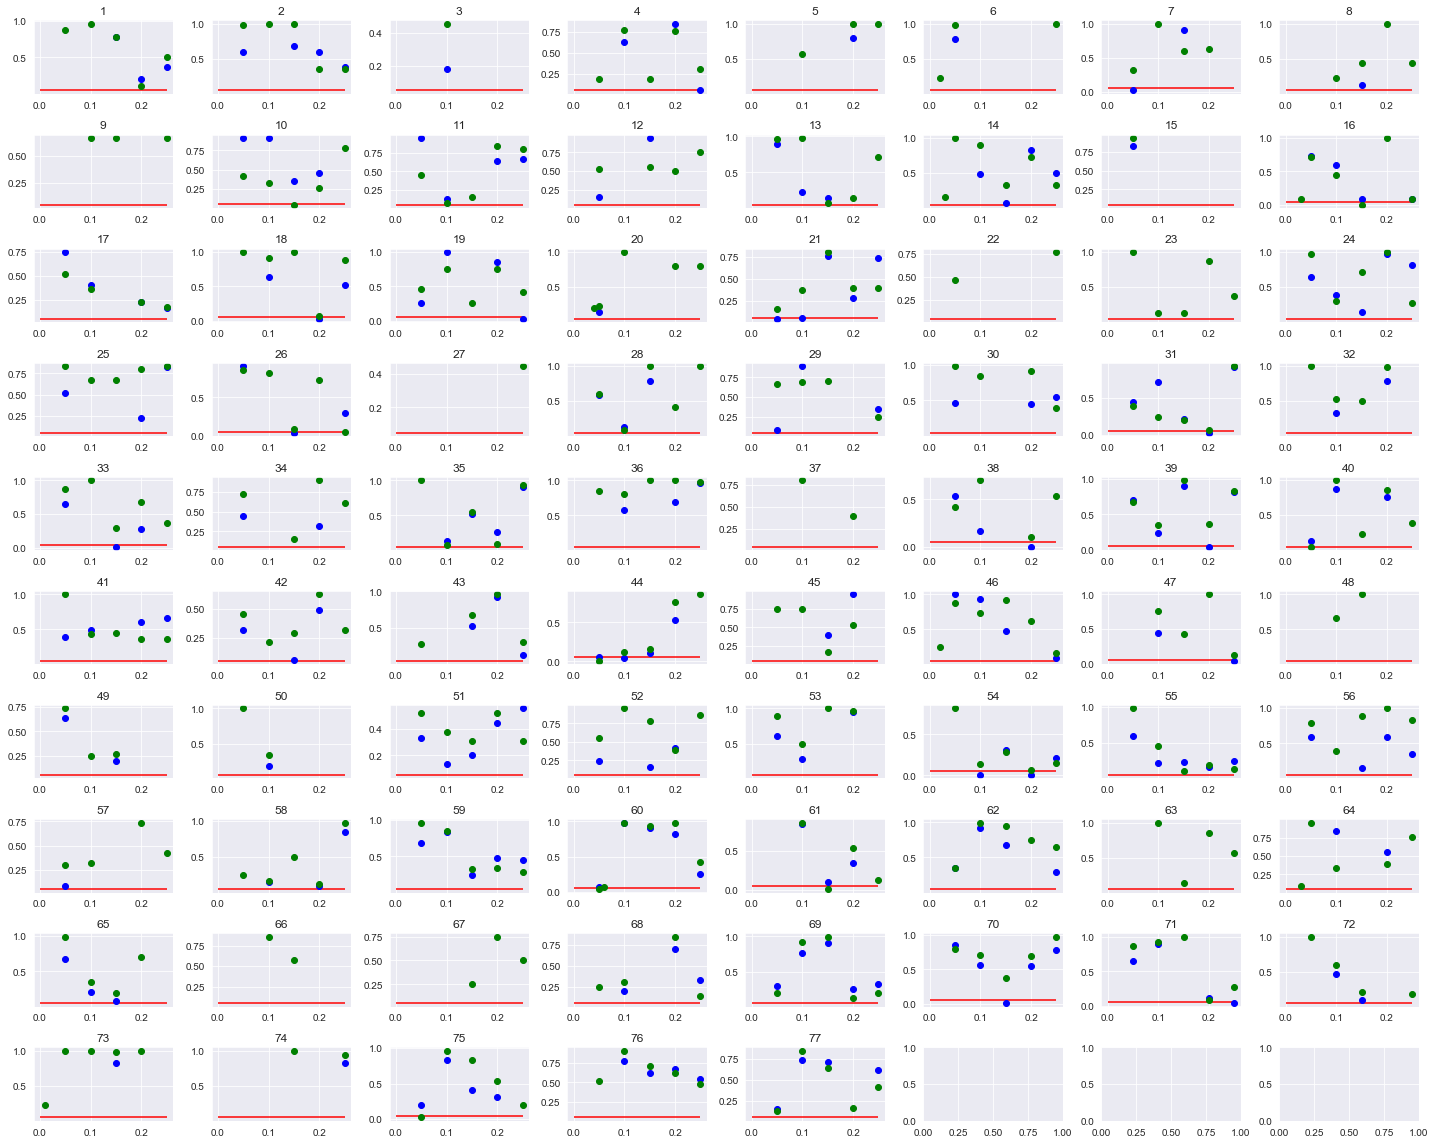

In [318]:
prod_id = analysis_df.ProductId.unique()
prod_id.sort()
p_val_array = []
p_val_ks_array = []
disc_array = []
for id_ in prod_id:
    df_id = analysis_df[analysis_df.ProductId==id_]
    disc = df_id.Discount.unique()
    disc.sort()
    a = df_id[df_id.Discount==disc[0]]['Quantity']
    p_val = []
    p_val_ks = []
    for d in disc[1:]:
        b = df_id[df_id.Discount==d]['Quantity']
        p_val.append(ttest_ind(a,b,equal_var=False)[1])
        p_val_ks.append(ks_2samp(a,b)[1])
    disc_array.append(disc[1:])
    p_val_array.append(p_val)
    p_val_ks_array.append(p_val_ks)


fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,0.0,0.25,color='r')
    axs[i].plot(disc_array[i],p_val_array[i],'bo')
    axs[i].plot(disc_array[i],p_val_ks_array[i],'go')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\welch_ks_all.png')


#### After accounting for the Bonferroni connection only 2 products survive the KS test. Hence there is no indication that there is a discernible effect of discounts on order quantities

## Q2 Do sales get drawn from a different distribution every year? Does the month when the products were ordered matter? 

#### Throughout the analysis we need to specify what our hypothesis is. We will set our tolerance value  $\alpha=0.05$. We will be performing the two tailed tests. Our Null hypothesis is that the the quantities ordered at various years (or months) have the same mean and variance as that of other years (months). Our alternative hypothesis is that the means and variance of the distributions at different years (months) don't have the same mean and variance. Thus this is a two tailed hypothesis test. Since the variance of the two distributions can be different and the sample sizes are not the same we need to do a Welch's t-test. We will also perform a Kolmogorov-Smirnov test.

In [580]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [581]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount, OrderDate,EmployeeId
               FROM orderdetail
               JOIN "order"
               ON orderdetail.OrderId = "order".Id
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,EmployeeId
0,10248,11,14.0,12,0.0,2012-07-04,5
1,10248,42,9.8,10,0.0,2012-07-04,5
2,10248,72,34.8,5,0.0,2012-07-04,5
3,10249,14,18.6,9,0.0,2012-07-05,6
4,10249,51,42.4,40,0.0,2012-07-05,6


In [582]:
df['month'] = pd.DatetimeIndex(df.OrderDate).month
df['year'] = pd.DatetimeIndex(df.OrderDate).year
df.drop('OrderDate',axis=1,inplace=True)
df.year.unique()

array([2012, 2013, 2014], dtype=int64)

#### Since there are only 3 years we can do a t-test for each year and see if there are differences

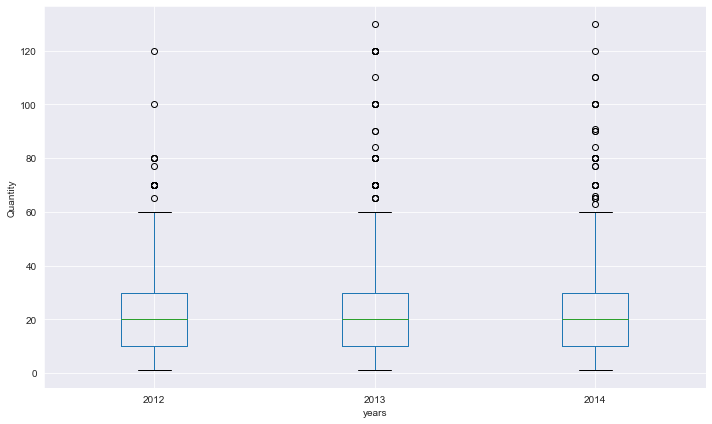

In [583]:
plt.figure(figsize=(10,6))
plt.xlabel('years')
plt.ylabel('Quantity')
df_2012 = df[df.year==2012]['Quantity']
df_2013 = df[df.year==2013]['Quantity']
df_2014 = df[df.year==2014]['Quantity']
all_yrs = pd.concat([df_2012,df_2013,df_2014],axis=1)
all_yrs.columns = ['2012','2013','2014']
all_yrs.boxplot(column=['2012', '2013','2014'])
plt.tight_layout()
plt.savefig('Figures\yrs_box.png')


#### As we can see comparing across years there is no statistical significant difference in the distributions from which each year was drawn

In [584]:
p_val_matrix_yr = np.zeros([3,3])
for i in range(2012,2015):
    for j in range(2012,2015):
        df_samp_1 = df[df.year==i]['Quantity']
        df_samp_2 = df[df.year==j]['Quantity']
        p_val_matrix_yr[i-2012,j-2012] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
df_yrs = pd.DataFrame(p_val_matrix_yr)
df_yrs.columns = ['2012','2013','2014']
df_yrs.index = ['2012','2013','2014']
df_yrs

,2012,2013,2014
2012,1.000000,0.699559,0.901191
2013,0.699559,1.000000,0.557163
2014,0.901191,0.557163,1.000000


### Are there any products that are statistically performing worse than when we started selling and need to be discontinued? Are there any products that are doing much better and need to be supported?

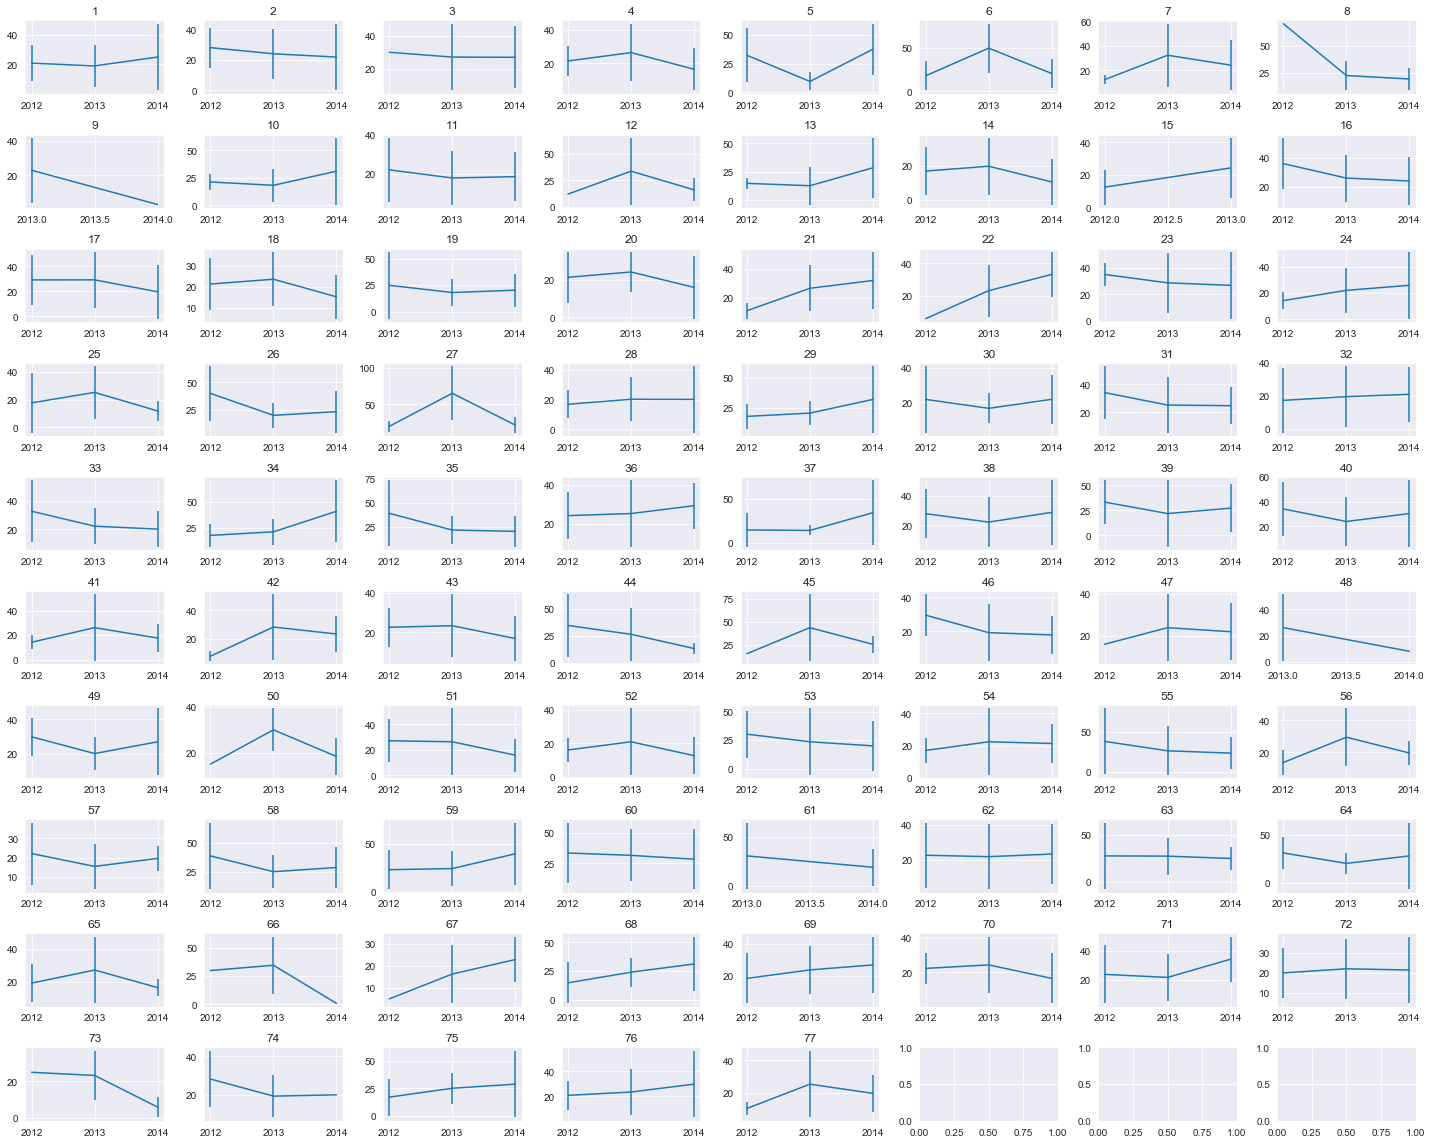

In [585]:
mean_std_df = df.groupby(['ProductId','year']).agg(['mean','std'])

mean_std_df.reset_index(level=1,inplace=True)

fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].errorbar(mean_std_df[mean_std_df.index==i+1]['year'],mean_std_df[mean_std_df.index==i+1]['Quantity']['mean'],
                    yerr=mean_std_df[mean_std_df.index==i+1]['Quantity']['std'])
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.savefig('Figures/q1_visual.png')

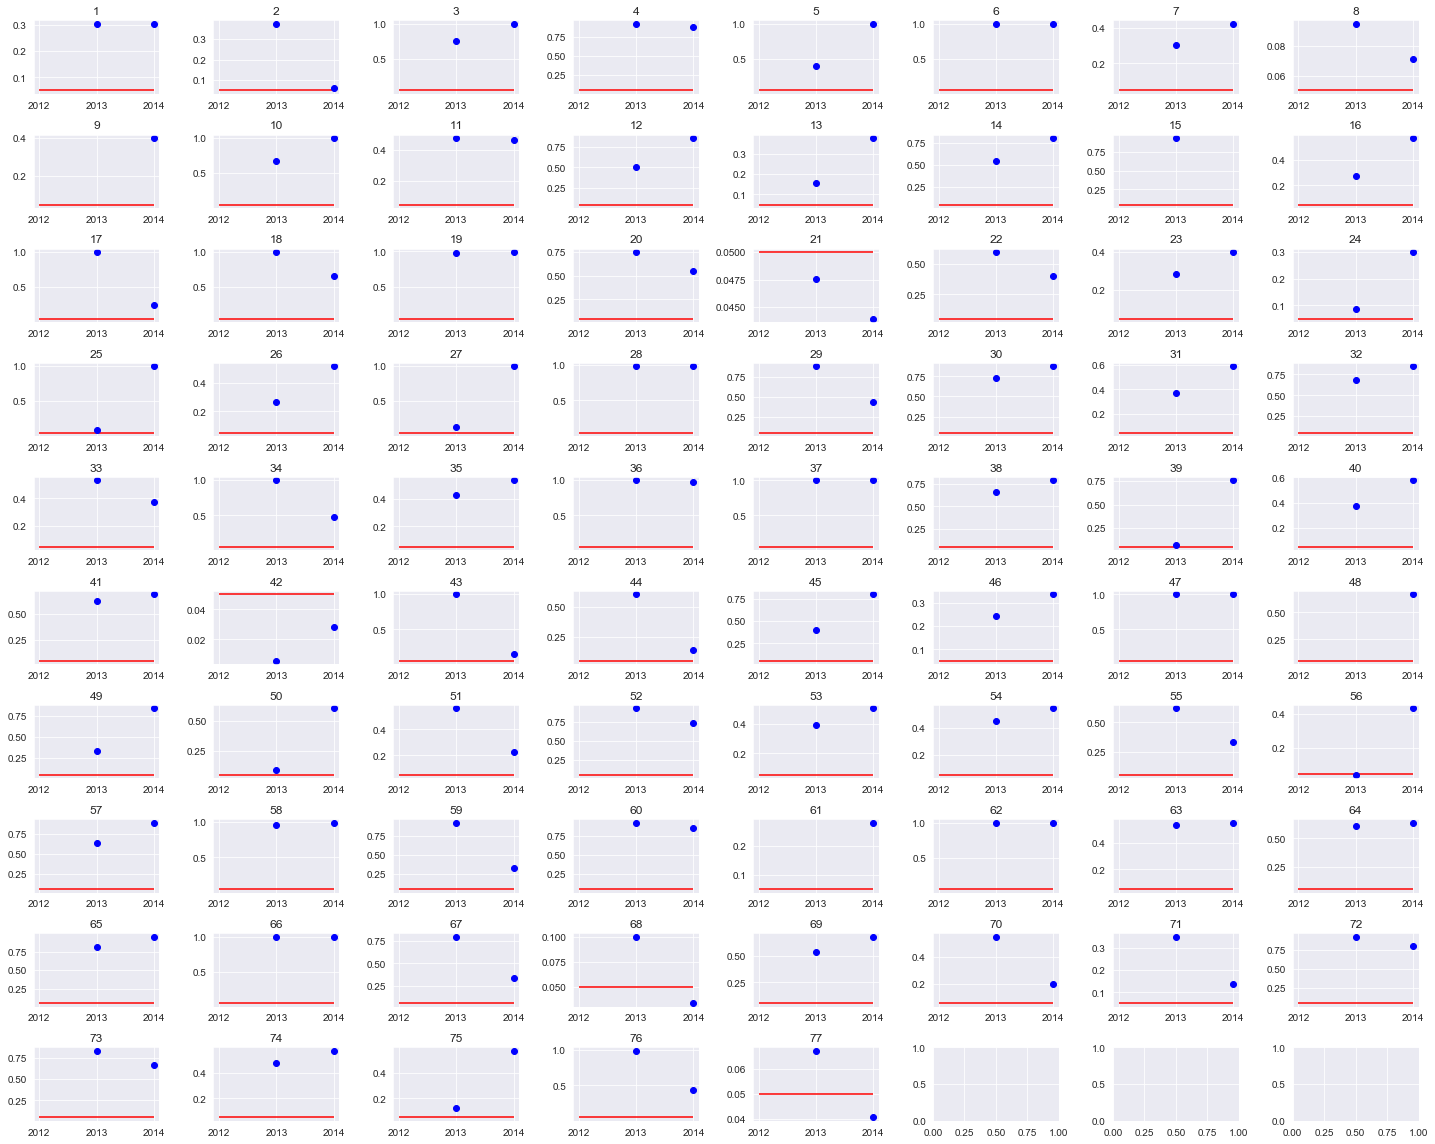

In [586]:
prod_id = df.ProductId.unique()
prod_id.sort()
p_val_array_yr = []
yr_array = []
for id_ in prod_id:
    df_id = df[df.ProductId==id_]
    yr = df_id.year.unique()
    yr.sort()
    a = df_id[df_id.year==yr[0]]['Quantity']
    p_val = []
    for d in yr[1:]:
        b = df_id[df_id.year==d]['Quantity']
        p_val.append(ks_2samp(a,b)[1])
    yr_array.append(yr[1:])
    p_val_array_yr.append(p_val)


fig, axs = plt.subplots(10,8, figsize=(20, 16))
axs = axs.ravel()
for i in range(77):
    axs[i].hlines(0.05,2012,2014,color='r')
    axs[i].plot(yr_array[i],p_val_array_yr[i],'bo')
    axs[i].set_title('%i'%(i+1))
plt.tight_layout()
#plt.title('p-values for Welch t-test for individual products at individual discount prices')
plt.savefig('Figures\welch_all_yr.png')

In [587]:
ind_ks_yr

[20, 41, 55, 67, 76]

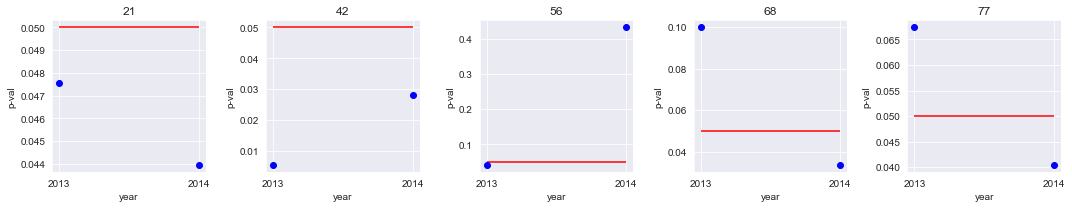

In [588]:
ind_ks_yr = []
for i,p in enumerate(p_val_array_yr):
    s = (np.array(p) < 0.05).sum()
    if s>0:
        ind_ks_yr.append(i)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
axs = axs.ravel()
for i,j in enumerate(ind_ks_yr):
    axs[i].hlines(0.05,str(2013),str(2014),color='r')
    axs[i].plot([str(2013),str(2014)],p_val_array_yr[j],'bo')
    axs[i].set_title('%i'%(j+1))
    axs[i].set_xlabel('year')
    axs[i].set_ylabel('p-val')
plt.tight_layout()
plt.savefig('Figures\ks_prod_yrs.png')


#### Only 5 products seem to indicate that the produts differ from original sales. We expect 4 if null hypothesis is true. Hence no products indicate a significant change in sales

### Doing an ANOVA analysis for month

In [589]:
formula = 'Quantity ~ C(month)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F    PR(>F)
C(month)    7395.980026    11.0  1.866405  0.039229
Residual  772003.656168  2143.0       NaN       NaN


#### Seems like its a little important. Let's do what we are not supposed to do, i.e. make one to one comparisons for each month

In [590]:
p_val_matrix = np.zeros([12,12])
p_val_matrix_ks = np.zeros([12,12])
for i in range(1,13):
    for j in range(1,13):
        df_samp_1 = df[df.month==i]['Quantity']
        df_samp_2 = df[df.month==j]['Quantity']
        p_val_matrix[i-1,j-1] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
        p_val_matrix_ks[i-1,j-1] = ks_2samp(df_samp_1,df_samp_2)[1]
        

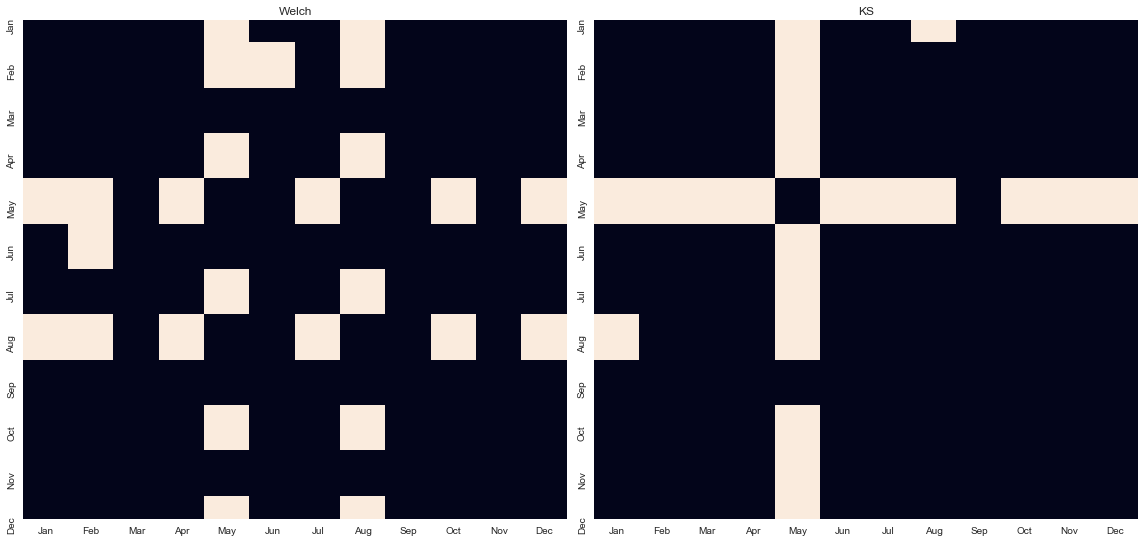

In [591]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))
axs = axs.ravel()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axs[0].set_title('Welch')
axs[1].set_title('KS')
sns.heatmap(p_val_matrix < 0.05, ax=axs[0],cbar=False,annot=False, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=months, xticklabels=months);
sns.heatmap(p_val_matrix_ks < 0.05, ax=axs[1],cbar=False,annot=False, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=months, xticklabels=months);
plt.tight_layout()
plt.savefig('Figures\heatmap_months.png')

#### As can be seen months May and August seem special in that they have the most deviations from other months. Lets plot them to visualize it

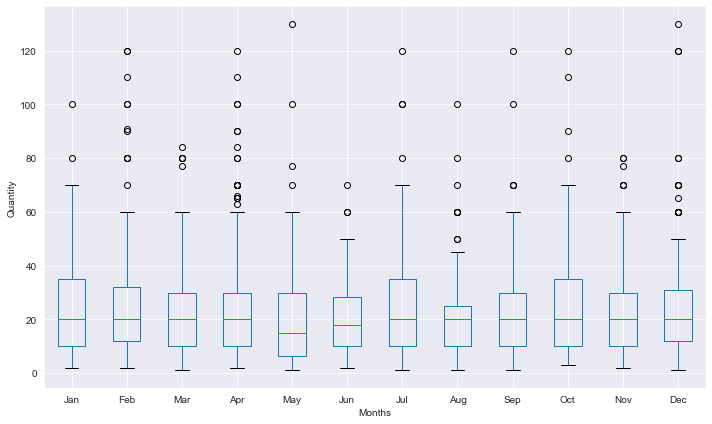

In [433]:
plt.figure(figsize=(10,6))
plt.xlabel('Months')
plt.ylabel('Quantity')
yr_list = []
for i in range(1,13):
    df_m = df[df.month==i]['Quantity']
    yr_list.append(df_m)
all_yrs = pd.concat(yr_list,axis=1)
all_yrs.columns = months
all_yrs.boxplot(column=months)
plt.tight_layout()
plt.savefig('Figures\months_box.png')



#### Although not visually compelling it seems that May and August have downward fluctuations in sales

## Q3 Is there a standout employee in terms of the distribution from which quantities sold are drawn ? Are there employees who are shipping their orders significantly late?

#### Throughout the analysis we need to specify what our hypothesis is. We will set our tolerance value  $\alpha=0.05$. We will be performing the two tailed tests. Our Null hypothesis is that the the quantities sold by various employees have the same meanand variance. Our alternative hypothesis is that the means and variance of all employess dont have the same mean and variance. Thus this is a two tailed hypothesis test. Since the variance of the two distributions can be different and the sample sizes are not the same we need to do a Welch's t-test. We will also perform a Kolmogorov-Smirnov test.

#### Selecting the relevant data

In [446]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount, OrderDate, ShippedDate,RequiredDate, EmployeeId
               FROM orderdetail
               JOIN "order"
               ON orderdetail.OrderId = "order".Id
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,RequiredDate,EmployeeId
0,10248,11,14.0,12,0.0,2012-07-04,2012-07-16,2012-08-01,5
1,10248,42,9.8,10,0.0,2012-07-04,2012-07-16,2012-08-01,5
2,10248,72,34.8,5,0.0,2012-07-04,2012-07-16,2012-08-01,5
3,10249,14,18.6,9,0.0,2012-07-05,2012-07-10,2012-08-16,6
4,10249,51,42.4,40,0.0,2012-07-05,2012-07-10,2012-08-16,6


In [447]:
df['EmployeeId'].unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7], dtype=int64)

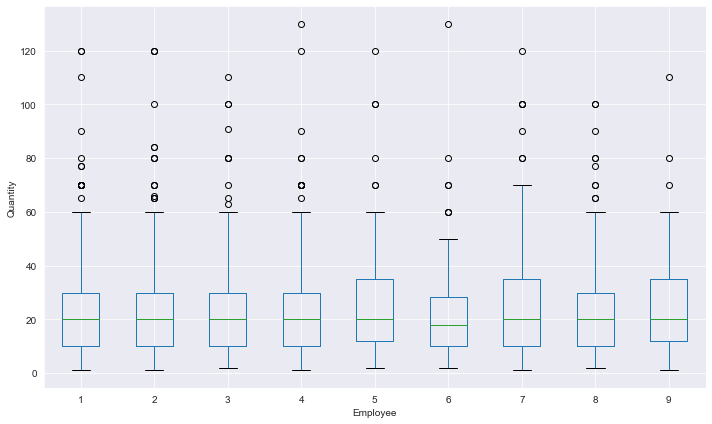

In [448]:
plt.figure(figsize=(10,6))
plt.xlabel('Employee')
plt.ylabel('Quantity')
emp = [1,2,3,4,5,6,7,8,9]
e_list = []
for i in range(1,10):
    df_e = df[df.EmployeeId==i]['Quantity']
    e_list.append(df_e)
all_yrs = pd.concat(e_list,axis=1)
all_yrs.columns = emp
all_yrs.boxplot(column=emp)
plt.tight_layout()
plt.savefig('Figures\employee_box.png')


#### Doing the ANOVA analysis for Employee yeilds no significant dependence on Employee

In [449]:
formula = 'Quantity ~ C(EmployeeId)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F   PR(>F)
C(EmployeeId)    4643.183282     8.0  1.607646  0.11745
Residual       774756.452913  2146.0       NaN      NaN


In [450]:
p_val_matrix_eid = np.zeros([9,9])
p_val_matrix_eid_ks = np.zeros([9,9])
for i in range(1,10):
    for j in range(1,10):
        df_samp_1 = df[df.EmployeeId==i]['Quantity']
        df_samp_2 = df[df.EmployeeId==j]['Quantity']
        p_val_matrix_eid[i-1,j-1] = ttest_ind(df_samp_1,df_samp_2,equal_var=False)[1]
        p_val_matrix_eid_ks[i-1,j-1] = ks_2samp(df_samp_1,df_samp_2)[1]

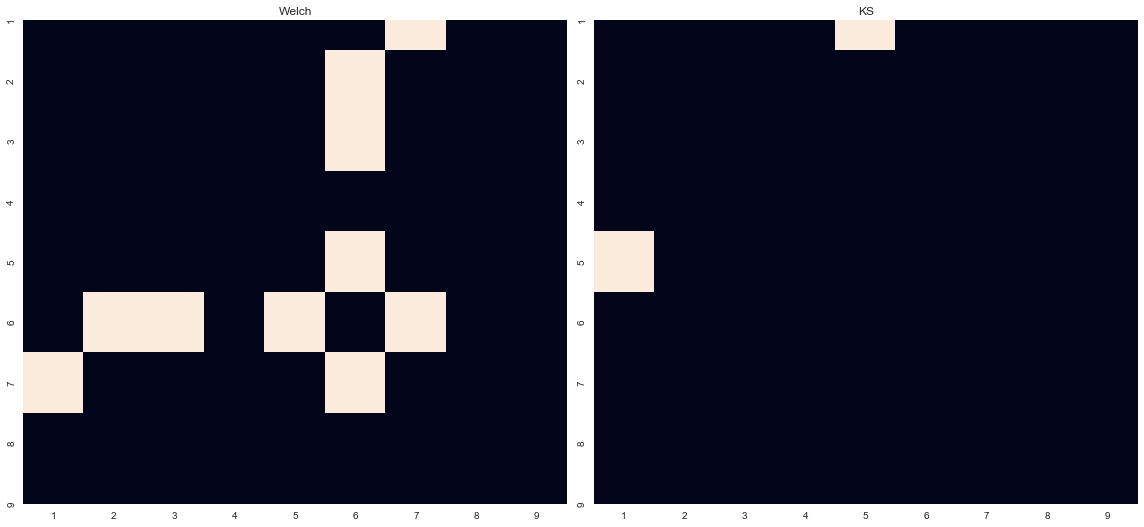

In [451]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))
axs = axs.ravel()
axs[0].set_title('Welch')
axs[1].set_title('KS')
sns.heatmap(p_val_matrix_eid < 0.05, ax=axs[0],cbar=False,annot=False, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=emp, xticklabels=emp);
sns.heatmap(p_val_matrix_eid_ks < 0.05 , ax=axs[1],cbar=False,annot=False, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=emp, xticklabels=emp);
plt.tight_layout()
plt.savefig('Figures\heatmap_emp.png')

#### Doing the comparison between employees it would seem that using the Welch t-test that Employee 6 is underperforming. However the KS is not successful in rejecting the Null Hypothesis. Hence we will conclude there is not strong preference for an employee to be overperforming or  consistent with the ANOVA analysis.

### Is there a employee who does not ship on time compared to the other employees?

In [452]:
late_dict = df[df.ShippedDate > df.RequiredDate]['EmployeeId'].value_counts().to_dict()
tot_sales = df['EmployeeId'].value_counts().to_dict()

In [453]:
prob_dict = {k : late_dict[k]/tot_sales[k] for k in late_dict.keys()}

#### The probability of late delivery for every employee. Employee 5 seems to have the best on time delivery record

In [454]:
prob_dict

{4: 0.06428571428571428,
 2: 0.058091286307053944,
 3: 0.040498442367601244,
 7: 0.056818181818181816,
 8: 0.03461538461538462,
 9: 0.07476635514018691,
 6: 0.02976190476190476,
 1: 0.014492753623188406,
 5: 0.008547008547008548}

#### Defining a z-test

In [459]:
def z_stat(p1,n1,p2,n2):
    p = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    return abs(z)

#### Designating employee 5 as the best employee in terms of deliveries on time, we perform z-tests to ask the question which employees need to pick up the pace. For a 2 -tailed test with $\alpha=0.05$ we get that for z > 1.96 the employees satisfy our alternative hypothesis are 4,2,7 and 9. We need to tell them to pick it up a little. However we need to be careful no to make it such an overwhelming metric that if falls victim to Goodheart's law

In [470]:
emp_list = []
zlist = []
for k in late_dict.keys():
    p1 = prob_dict[5]
    n1 = tot_sales[5]
    p2 = prob_dict[k]
    n2 = tot_sales[k]
    z_val = z_stat(p1,n1,p2,n2)
    zlist.append(z_val)
    if z_val > 1.96:
        emp_list.append(k)
print('The employees that need to pick up the pace are', emp_list)

The employees that need to pick up the pace are [4, 2, 7, 9]


# Q4 Are there regions that are growing or decreasing in overall sales ? Are there products that are growing or decreasing in overall sales

In [478]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [489]:
cur.execute("""SELECT Customer.Id,Region,Country,"order".Id as OrderId,EmployeeId,ProductId ,
                Quantity, OrderDate, Product.Id, CategoryId, CategoryName
               FROM Customer
               JOIN "order"
               ON Customer.Id="order".CustomerId
               JOIN orderdetail
               ON "order".Id = orderdetail.OrderId
               JOIN product
               ON orderdetail.ProductId = Product.Id
               JOIN Category
               ON Product.CategoryId = Category.Id
               """)

In [490]:
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df['year'] = pd.DatetimeIndex(df.OrderDate).year
df.head(10)

,Id,Region,Country,OrderId,EmployeeId,ProductId,Quantity,OrderDate,Id,CategoryId,CategoryName,year
0,VINET,Western Europe,France,10248,5,11,12,2012-07-04,11,4,Dairy Products,2012
1,VINET,Western Europe,France,10248,5,42,10,2012-07-04,42,5,Grains/Cereals,2012
2,VINET,Western Europe,France,10248,5,72,5,2012-07-04,72,4,Dairy Products,2012
3,TOMSP,Western Europe,Germany,10249,6,14,9,2012-07-05,14,7,Produce,2012
4,TOMSP,Western Europe,Germany,10249,6,51,40,2012-07-05,51,7,Produce,2012
5,HANAR,South America,Brazil,10250,4,41,10,2012-07-08,41,8,Seafood,2012
6,HANAR,South America,Brazil,10250,4,51,35,2012-07-08,51,7,Produce,2012
7,HANAR,South America,Brazil,10250,4,65,15,2012-07-08,65,2,Condiments,2012
8,VICTE,Western Europe,France,10251,3,22,6,2012-07-08,22,5,Grains/Cereals,2012
9,VICTE,Western Europe,France,10251,3,57,15,2012-07-08,57,5,Grains/Cereals,2012


#### The question we are asking is whether there is change between years at the rate at which the overall quantities are sold per region. In order to do this we will first divide the data among regions and among the years. We will then calculate an effective probability of a unit being sold per day. Then we will perform a z-test over the probabilitties to find out if a region is growing or shrinking.

In [575]:
regions = []
z_reg = []
p_min = []
p_max = []
fact = 24*60
for reg in df.Region.unique():
    df_reg = df[df.Region==reg]
    regions.append(reg)
    yr = df_reg.year.unique()
    df_reg_min = df_reg[df_reg.year==yr.min()]
    df_reg_max = df_reg[df_reg.year==yr.max()]
    delta_days_min = fact*((pd.DatetimeIndex([str(yr.min())+'/12/31']) - pd.DatetimeIndex(df_cat_min.OrderDate).min()).days[0]+1)
    delta_days_max = fact*((pd.DatetimeIndex(df_cat_max.OrderDate).max() - pd.DatetimeIndex([str(yr.max())+'/1/1'])).days[0]+1)
    prob_min = df_reg_min['Quantity'].sum()/(delta_days_min)
    p_min.append(prob_min)
    prob_max = df_reg_max['Quantity'].sum()/(delta_days_max)
    p_max.append(prob_max)
    z_reg.append(z_stat(prob_min,delta_days_min,prob_max,delta_days_max))
#    print(reg, prob_min,prob_max)

In [576]:
df_region_result = pd.DataFrame(list(zip(regions,p_min,p_max,z_reg)),columns = ['Region','p_2012','p_2014','z-statistic'])
df_region_result

,Region,p_2012,p_2014,z-statistic
0,Western Europe,0.015649,0.034579,40.454319
1,South America,0.004175,0.012373,30.588491
2,Central America,0.000818,0.001130,3.283594
3,North America,0.007328,0.019786,36.290699
4,Northern Europe,0.002423,0.005969,18.429383
5,Scandinavia,0.000818,0.001190,3.870762
6,Southern Europe,0.001776,0.003979,13.770165
7,British Isles,0.004270,0.007088,12.409567
8,Eastern Europe,0.000180,0.000557,6.654723


#### We can repeat the same exercise with sales of products in the first and last year as with region

In [577]:
categories = []
z_reg = []
p_min = []
p_max = []
fact = 24*60
for cat in df.CategoryName.unique():
    df_cat = df[df.CategoryName==cat]
    categories.append(cat)
    yr = df_cat.year.unique()
    df_cat_min = df_cat[df_cat.year==yr.min()]
    df_cat_max = df_cat[df_cat.year==yr.max()]
    delta_days_min = fact*((pd.DatetimeIndex([str(yr.min())+'/12/31']) - pd.DatetimeIndex(df_cat_min.OrderDate).min()).days[0]+1)
    delta_days_max = fact*((pd.DatetimeIndex(df_cat_max.OrderDate).max() - pd.DatetimeIndex([str(yr.max())+'/1/1'])).days[0]+1)
    prob_min = df_cat_min['Quantity'].sum()/(delta_days_min)
    p_min.append(prob_min)
    prob_max = df_cat_max['Quantity'].sum()/(delta_days_max)
    p_max.append(prob_max)
    z_reg.append(z_stat(prob_min,delta_days_min,prob_max,delta_days_max))
#    print(cat, prob_min,prob_max)


In [579]:
df_product_result = pd.DataFrame(list(zip(categories,p_min,p_max,z_reg)),columns = ['Category','p_2012','p_2014','z-statistic'])
df_product_result

,Category,p_2012,p_2014,z-statistic
0,Dairy Products,0.007455,0.014269,22.126396
1,Grains/Cereals,0.002083,0.007446,26.854013
2,Produce,0.002118,0.004652,14.744752
3,Seafood,0.005046,0.014782,33.390538
4,Condiments,0.003774,0.007429,16.397729
5,Confections,0.005307,0.012869,26.845962
6,Beverages,0.007151,0.019444,36.230211
7,Meat/Poultry,0.003792,0.005759,9.416188


#### It seems that the demand did increase for both products and for every region between 2012 and 2014. This could reflect seasonality since 2014 data is captured till May while 2012 data is catured after July. However there is no reason for seasonality in staple foods. So we conclude that indeed the sales have increased from 2012 to 2014